<a href="https://colab.research.google.com/github/Hrtsh-Ynkzn/SAMURAI/blob/main/Study/Financial_Indicators_of_US_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

米国株の 200 以上の財務指標 (2014 ～ 2018 年)

https://www.kaggle.com/datasets/cnic92/200-financial-indicators-of-us-stocks-20142018

2014年のデータを使って、2015年にその企業の株が上がるか(class=1)・下がるか(class=0)を予測する。

# Install

In [ ]:
%%bash
pip install kaggle > /dev/null           # KaggleのAPIを利用するため
pip install duckdb-engine > /dev/null    # Python内でSQLを用いる
pip install optuna > /dev/null
apt install -y graphviz > /dev/null
pip install graphviz shap > /dev/null

# Import

In [ ]:
# 標準ライブラリ
import pandas as pd
import numpy as np
from scipy import stats
import math
import os
import json                                            # JSON形式のデータを読み込む。KaggleのAPIを利用するために必要
import subprocess
import pickle
import logging

# SQLを使えるようにするためのライブラリのインポート
import duckdb

# 標準化の処理をするためのクラスをインポート
from sklearn.preprocessing import StandardScaler

# 見える化ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix             # 散布行列を出力する関数をインポート

# 分析ライブラリ
import lightgbm as lgb
import optuna.integration.lightgbm as lgb_optuna       # ハイパーパラメータチューニング
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report

# GoogoleドライブをGoogle Colabにマウント(連携)させるライブラリ
from google.colab import drive

In [ ]:
# 使用したパッケージのversionをrequirementsファイルに格納し、記録しておく。version管理。
pkglist = ['optuna', 'shap']

# run()で外部コマンドを呼ぶ
subprocess.run('cp /dev/null requirements.txt', shell = True)    # cp:ファイルをコピーする

for pkg in pkglist:
    subprocess.run(f'pip freeze | grep {pkg} >> requirements.txt', shell = True)
    # pip freeze:インストール済みのパッケージをrequirements形式で出力する

# データダウンロード

・データは、Kaggleの過去のコンペティションで使われたデータを利用<br>

In [ ]:
# Googleドライブをマウント(連携)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# KaggleのAPIを利用するための設定
# 初回のみJSONファイルをダウンロードして、Google Driveに保存する必要がある

f = open("/content/drive/MyDrive/kaggle.json", 'r')     # JSONファイルを開く
json_data = json.load(f)                                # 開いたファイルをJSONとして読み込む
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

# データ準備

In [ ]:
!kaggle datasets download -d ulrikthygepedersen/online-retail-dataset

 68% 5.00M/7.38M [00:00<00:00, 22.6MB/s]
100% 7.38M/7.38M [00:00<00:00, 32.4MB/s]


In [ ]:
# Kaggleの各コンペページから、APIコマンドを取得し実施
!kaggle datasets download -d cnic92/200-financial-indicators-of-us-stocks-20142018

 34% 5.00M/14.8M [00:00<00:00, 36.8MB/s]
100% 14.8M/14.8M [00:00<00:00, 90.2MB/s]


In [ ]:
!unzip '/content/200-financial-indicators-of-us-stocks-20142018.zip'

Archive:  /content/200-financial-indicators-of-us-stocks-20142018.zip
  inflating: 2014_Financial_Data.csv  
  inflating: 2015_Financial_Data.csv  
  inflating: 2016_Financial_Data.csv  
  inflating: 2017_Financial_Data.csv  
  inflating: 2018_Financial_Data.csv  


In [ ]:
# 解凍したZIPには、CSVファイルが含まれている。CSVファイルを読み込んで、Pandasデータフレーム化する
df = pd.read_csv('/content/2014_Financial_Data.csv')

#df.head()    # 確認用

## 列名の修正

In [ ]:
# 先頭列名をCompanyに変更
df = df.rename(columns = {'Unnamed: 0' : 'Company'})

In [ ]:
# カラム名の記号をすべて'_'に変換
rename_col_names = []

for r in df.columns:
    rename_col_names.append(r.replace(' ', '_')
                             .replace('(', '_')
                             .replace(')', '_')
                             .replace(',', '_'))

df.columns = rename_col_names

#pd.set_option('display.max_columns', 223)  # 列を省略なしで表示する
#df.head()                                  # 確認用

# データ加工

In [ ]:
# まずデータの観察
# カラムごとの基準統計量

# pd.set_option('display.max_rows', 4000)   # 行を省略なしで表示する
pd.set_option('display.max_columns', 223)   # 列を省略なしで表示する
df.describe(include = float)                # includeオプションでfloat型の列のみ算出

,Revenue,Revenue_Growth,Cost_of_Revenue,Gross_Profit,R&D_Expenses,SG&A_Expense,Operating_Expenses,Operating_Income,Interest_Expense,Earnings_before_Tax,Income_Tax_Expense,Net_Income_-_Non-Controlling_int,Net_Income_-_Discontinued_ops,Net_Income,Preferred_Dividends,Net_Income_Com,EPS,EPS_Diluted,Weighted_Average_Shs_Out,Weighted_Average_Shs_Out__Dil_,Dividend_per_Share,Gross_Margin,EBITDA_Margin,EBIT_Margin,Profit_Margin,Free_Cash_Flow_margin,EBITDA,EBIT,Consolidated_Income,Earnings_Before_Tax_Margin,Net_Profit_Margin,Cash_and_cash_equivalents,Short-term_investments,Cash_and_short-term_investments,Receivables,Inventories,Total_current_assets,Property__Plant_&_Equipment_Net,Goodwill_and_Intangible_Assets,Long-term_investments,Tax_assets,Total_non-current_assets,Total_assets,Payables,Short-term_debt,Total_current_liabilities,Long-term_debt,Total_debt,Deferred_revenue,Tax_Liabilities,Deposit_Liabilities,Total_non-current_liabilities,Total_liabilities,Other_comprehensive_income,Retained_earnings__deficit_,Total_shareholders_equity,Investments,Net_Debt,Other_Assets,Other_Liabilities,Depreciation_&_Amortization,Stock-based_compensation,Operating_Cash_Flow,Capital_Expenditure,Acquisitions_and_disposals,Investment_purchases_and_sales,Investing_Cash_flow,Issuance__repayment__of_debt,Issuance__buybacks__of_shares,Dividend_payments,Financing_Cash_Flow,Effect_of_forex_changes_on_cash,Net_cash_flow_/_Change_in_cash,Free_Cash_Flow,Net_Cash/Marketcap,priceBookValueRatio,priceToBookRatio,priceToSalesRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,dividendYield,enterpriseValueMultiple,priceFairValue,ebitperRevenue,ebtperEBIT,niperEBT,grossProfitMargin,operatingProfitMargin,pretaxProfitMargin,netProfitMargin,effectiveTaxRate,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,nIperEBT,eBTperEBIT,eBITperRevenue,payablesTurnover,inventoryTurnover,fixedAssetTurnover,assetTurnover,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,daysOfInventoryOutstanding,operatingCycle,daysOfPayablesOutstanding,cashConversionCycle,debtRatio,debtEquityRatio,longtermDebtToCapitalization,totalDebtToCapitalization,interestCoverage,cashFlowToDebtRatio,companyEquityMultiplier,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,payoutRatio,operatingCashFlowSalesRatio,freeCashFlowOperatingCashFlowRatio,cashFlowCoverageRatios,shortTermCoverageRatios,capitalExpenditureCoverageRatios,dividendpaidAndCapexCoverageRatios,dividendPayoutRatio,Revenue_per_Share,Net_Income_per_Share,Operating_Cash_Flow_per_Share,Free_Cash_Flow_per_Share,Cash_per_Share,Book_Value_per_Share,Tangible_Book_Value_per_Share,Shareholders_Equity_per_Share,Interest_Debt_per_Share,Market_Cap,Enterprise_Value,PE_ratio,Price_to_Sales_Ratio,POCF_ratio,PFCF_ratio,PB_ratio,PTB_ratio,EV_to_Sales,Enterprise_Value_over_EBITDA,EV_to_Operating_cash_flow,EV_to_Free_cash_flow,Earnings_Yield,Free_Cash_Flow_Yield,Debt_to_Equity,Debt_to_Assets,Net_Debt_to_EBITDA,Current_ratio,Interest_Coverage,Income_Quality,Dividend_Yield,Payout_Ratio,SG&A_to_Revenue,R&D_to_Revenue,Intangibles_to_Total_Assets,Capex_to_Operating_Cash_Flow,Capex_to_Revenue,Capex_to_Depreciation,Stock-based_compensation_to_Revenue,Graham_Number,ROIC,Return_on_Tangible_Assets,Graham_Net-Net,Working_Capital,Tangible_Asset_Value,Net_Current_Asset_Value,Invested_Capital,Average_Receivables,Average_Payables,Average_Inventory,Days_Sales_Outstanding,Days_Payables_Outstanding,Days_of_Inventory_on_Hand,Receivables_Turnover,Payables_Turnover,Inventory_Turnover,ROE,Capex_per_Share,Gross_Profit_Growth,EBIT_Growth,Operating_Income_Growth,Net_Income_Growth,EPS_Growth,EPS_Diluted_Growth,Weighted_Average_Shares_Growth,Weighted_Average_Shares_Diluted_Growth,Dividends_per_Share_Growth,Operating_Cash_Flow_growth,Free_Cash_Flow_growth,10Y_Revenue_Growth__per_Share_,5Y_Revenue_Growth__per_Share_,3Y_Revenue_Growth__per_Share_,10Y_Operating_CF_Growth__per_Share_,5Y_Oper

In [ ]:
df.median()

<ipython-input-14-6d467abf240d>:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.median()


Revenue                 4.349010e+08
Revenue_Growth          6.185000e-02
Cost_of_Revenue         1.414420e+08
Gross_Profit            1.908760e+08
R&D_Expenses            0.000000e+00
                            ...     
Debt_Growth             0.000000e+00
R&D_Expense_Growth      0.000000e+00
SG&A_Expenses_Growth    6.880000e-02
2015_PRICE_VAR_[%]     -5.281842e+00
Class                   0.000000e+00
Length: 223, dtype: float64

In [ ]:
# フルマッチを起こしてしまうカラムは先に削除しておく。これまでの情報でカラムを特定済み
df = df.drop(columns = ['2015_PRICE_VAR_[%]',           # 過去の検証にてフルマッチを起こす要因と確定
                        'Days_of_Inventory_on_Hand'])   # 1回目の列選択にてdaysOfSalesOutstandingと相関が1であることが判明

In [ ]:
# 数値の列のみを抽出する
df_float_only = df.select_dtypes(include = float)

array([[<Axes: title={'center': 'Revenue'}>,
        <Axes: title={'center': 'Revenue_Growth'}>,
        <Axes: title={'center': 'Cost_of_Revenue'}>,
        <Axes: title={'center': 'Gross_Profit'}>,
        <Axes: title={'center': 'R&D_Expenses'}>,
        <Axes: title={'center': 'SG&A_Expense'}>,
        <Axes: title={'center': 'Operating_Expenses'}>,
        <Axes: title={'center': 'Operating_Income'}>,
        <Axes: title={'center': 'Interest_Expense'}>,
        <Axes: title={'center': 'Earnings_before_Tax'}>,
        <Axes: title={'center': 'Income_Tax_Expense'}>,
        <Axes: title={'center': 'Net_Income_-_Non-Controlling_int'}>,
        <Axes: title={'center': 'Net_Income_-_Discontinued_ops'}>,
        <Axes: title={'center': 'Net_Income'}>,
        <Axes: title={'center': 'Preferred_Dividends'}>],
       [<Axes: title={'center': 'Net_Income_Com'}>,
        <Axes: title={'center': 'EPS'}>,
        <Axes: title={'center': 'EPS_Diluted'}>,
        <Axes: title={'center': 'Weigh

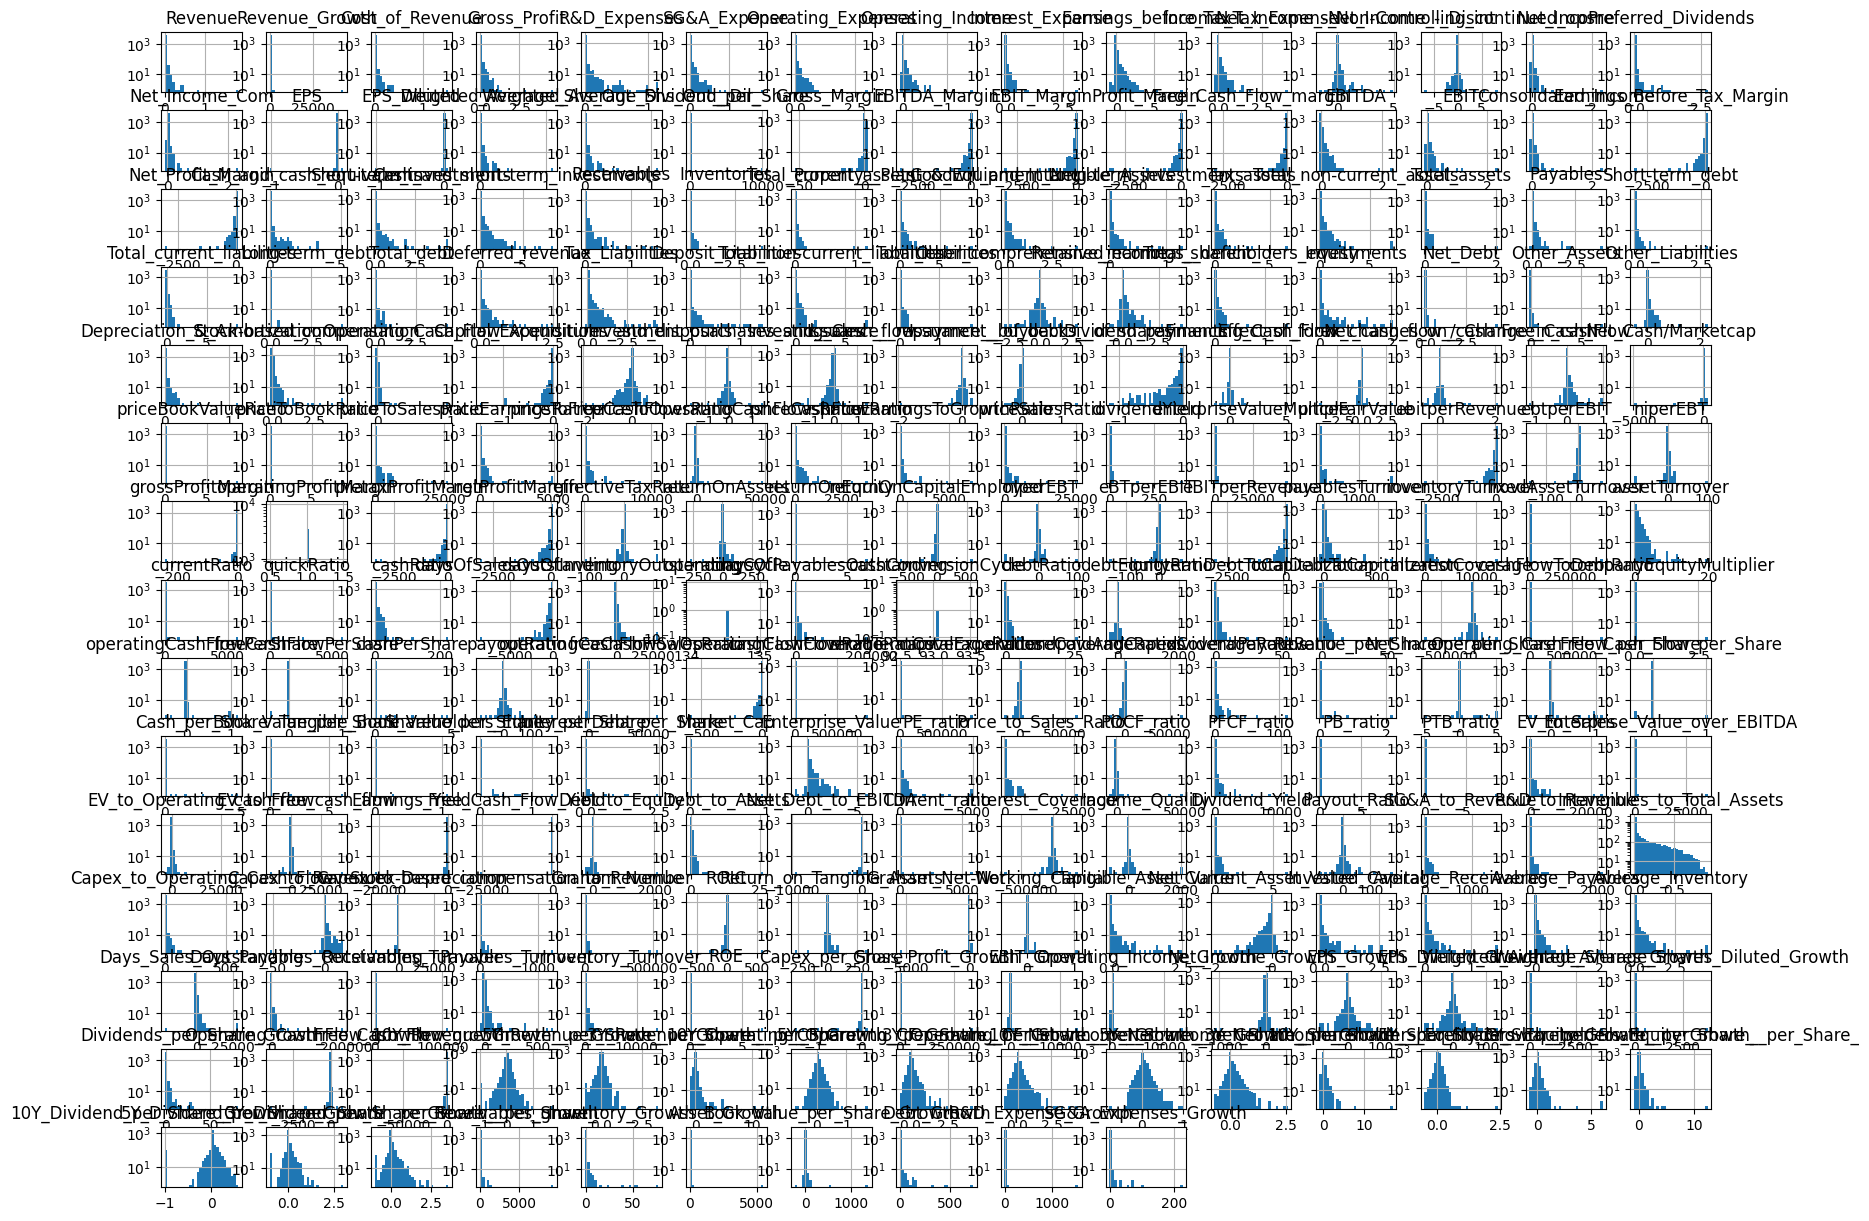

In [ ]:
# 各列のヒストグラムを描画(y軸を対数表示)
df_float_only.hist(figsize = (20, 15), bins = 30, log = True)

極端な値が散見される。おそらく外れ値なので、欠損値の補完は平均値ではなく中央値を採用する。

## 標準化

In [ ]:
# インスタンス化
scaler = StandardScaler()

# fit_transform()を用いて、今回は変換モデル作成とスケール変換を一気に行う。
df_scaler = scaler.fit_transform(df_float_only)
df_scaler # ndarrayオブジェクトとして出力される

array([[ 1.75642253, -0.01846268,  1.16203154, ..., -0.06614375,
        -0.02304054, -0.11857897],
       [-0.05498024, -0.01669799, -0.02944951, ...,         nan,
         0.04062782,  0.28724971],
       [ 2.37094786, -0.01833582,  2.44835992, ..., -0.05808252,
        -0.02304054, -0.07641827],
       ...,
       [-0.14962104,         nan, -0.12084321, ...,         nan,
                nan,         nan],
       [-0.14196298, -0.01817112, -0.11133922, ..., -0.07269951,
        -0.02304054, -0.06756027],
       [-0.14966366, -0.01808876, -0.1210309 , ..., -0.09722487,
        -0.0123107 , -0.0871075 ]])

In [ ]:
# データフレーム化し、カラム名も指定
df_scaler = pd.DataFrame(df_scaler, columns = df_float_only.columns)

#df_scaler.head()    # 確認用

## 列の選択

### Classごとの差が大きいカラムを採用

In [ ]:
# 除外されたカラム'Class', 'Sector'を追加
df_scaler['Class']  = df['Class']
df_scaler['Sector'] = df['Sector']

In [ ]:
# Classを基準にグルーピング
grouped = df_scaler.groupby('Class')
grouped.size()

Class
0    2174
1    1634
dtype: int64

In [ ]:
grouped_mean = grouped.mean()
grouped_mean = grouped_mean.T     # 転置

<ipython-input-22-cc048db62cb2>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_mean = grouped.mean()


In [ ]:
grouped_mean['diff_abs'] = abs(grouped_mean[0] - grouped_mean[1])

In [ ]:
# 確認用
#print(grouped_mean)
grouped_mean.head()

Class,0,1,diff_abs
Revenue,0.013978,-0.018701,0.032678
Revenue_Growth,0.013087,-0.017830,0.030917
Cost_of_Revenue,0.013531,-0.018106,0.031636
Gross_Profit,0.012857,-0.017287,0.030145
R&D_Expenses,-0.016578,0.022294,0.038872


In [ ]:
# 差が大きい順に20の変数を使ってみる
top20_col = grouped_mean.sort_values('diff_abs', ascending = False).head(20).index    # 今転置しているので、行を抽出する
top20_col = list(top20_col)                                                           # リスト型に変換

top20_col.append('Sector')
top20_col.append('Class')

In [ ]:
df_scaler_select20 = df_scaler[top20_col]
df_scaler_select20.head()

,5Y_Revenue_Growth__per_Share_,5Y_Operating_CF_Growth__per_Share_,Short-term_investments,Cash_and_short-term_investments,3Y_Dividend_per_Share_Growth__per_Share_,5Y_Net_Income_Growth__per_Share_,10Y_Revenue_Growth__per_Share_,cashRatio,Capital_Expenditure,3Y_Net_Income_Growth__per_Share_,Property__Plant_&_Equipment_Net,Deferred_revenue,daysOfSalesOutstanding,Enterprise_Value,Inventory_Growth,totalDebtToCapitalization,Dividends_per_Share_Growth,Gross_Margin,Weighted_Average_Shs_Out__Dil_,EBITDA_Margin,Sector,Class
0,-0.169064,-0.249506,0.878242,2.551754,0.149752,-0.400368,0.003077,-0.254911,-0.897928,-0.174979,0.913535,-0.130746,-0.036170,8.168793,-0.084924,0.044408,-0.050410,0.005997,1.005310,0.058927,Consumer Defensive,0
1,NaN,NaN,0.163298,0.138083,NaN,NaN,NaN,-0.219507,0.060114,NaN,-0.124201,-0.097306,-0.097606,NaN,NaN,0.297673,-0.089254,-0.207611,-0.113291,0.056061,Consumer Defensive,0
2,0.293918,0.161612,-0.122934,-0.116382,0.489343,0.099028,0.446060,-0.290031,-0.492184,0.214258,0.658246,-0.130746,0.149840,0.754535,-0.030341,0.370191,0.045728,-0.248128,0.306946,0.056477,Consumer Defensive,1
3,-0.353282,0.262831,-0.122934,-0.182429,-0.139400,-0.334771,-0.322868,-0.286633,0.041359,-0.187727,-0.046415,-0.130746,-0.020131,0.141577,-0.098274,1.231445,-0.089254,-0.171617,-0.100792,0.056441,Consumer Defensive,1
4,0.064376,0.113009,-0.122934,0.004586,0.301066,0.067905,0.242817,-0.270147,-0.044983,-0.150121,0.047217,-0.130746,0.033993,1.184162,-0.070937,0.270936,0.007551,-0.106791,0.134845,0.058369,Consumer Defensive,1


## 欠損値の補完<br>
今回は中央値で補完を行う

In [ ]:
# 欠損値を中央値で補完する
df_scaler_select20 = df_scaler_select20.fillna(df_scaler_select20.median())

# 確認用
df_scaler_select20.head()

<ipython-input-27-6dcd3832d1ee>:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_scaler_select20 = df_scaler_select20.fillna(df_scaler_select20.median())


,5Y_Revenue_Growth__per_Share_,5Y_Operating_CF_Growth__per_Share_,Short-term_investments,Cash_and_short-term_investments,3Y_Dividend_per_Share_Growth__per_Share_,5Y_Net_Income_Growth__per_Share_,10Y_Revenue_Growth__per_Share_,cashRatio,Capital_Expenditure,3Y_Net_Income_Growth__per_Share_,Property__Plant_&_Equipment_Net,Deferred_revenue,daysOfSalesOutstanding,Enterprise_Value,Inventory_Growth,totalDebtToCapitalization,Dividends_per_Share_Growth,Gross_Margin,Weighted_Average_Shs_Out__Dil_,EBITDA_Margin,Sector,Class
0,-0.169064,-0.249506,0.878242,2.551754,0.149752,-0.400368,0.003077,-0.254911,-0.897928,-0.174979,0.913535,-0.130746,-0.036170,8.168793,-0.084924,0.044408,-0.050410,0.005997,1.005310,0.058927,Consumer Defensive,0
1,0.044882,-0.247276,0.163298,0.138083,-0.139400,-0.334771,0.069776,-0.219507,0.060114,-0.187727,-0.124201,-0.097306,-0.097606,-0.243785,-0.075037,0.297673,-0.089254,-0.207611,-0.113291,0.056061,Consumer Defensive,0
2,0.293918,0.161612,-0.122934,-0.116382,0.489343,0.099028,0.446060,-0.290031,-0.492184,0.214258,0.658246,-0.130746,0.149840,0.754535,-0.030341,0.370191,0.045728,-0.248128,0.306946,0.056477,Consumer Defensive,1
3,-0.353282,0.262831,-0.122934,-0.182429,-0.139400,-0.334771,-0.322868,-0.286633,0.041359,-0.187727,-0.046415,-0.130746,-0.020131,0.141577,-0.098274,1.231445,-0.089254,-0.171617,-0.100792,0.056441,Consumer Defensive,1
4,0.064376,0.113009,-0.122934,0.004586,0.301066,0.067905,0.242817,-0.270147,-0.044983,-0.150121,0.047217,-0.130746,0.033993,1.184162,-0.070937,0.270936,0.007551,-0.106791,0.134845,0.058369,Consumer Defensive,1


## 選択した列の評価を行う

In [ ]:
# 各列の相関係数を算出する
df_scaler_select20.corr()

<ipython-input-28-90a312d08630>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_scaler_select20.corr()


,5Y_Revenue_Growth__per_Share_,5Y_Operating_CF_Growth__per_Share_,Short-term_investments,Cash_and_short-term_investments,3Y_Dividend_per_Share_Growth__per_Share_,5Y_Net_Income_Growth__per_Share_,10Y_Revenue_Growth__per_Share_,cashRatio,Capital_Expenditure,3Y_Net_Income_Growth__per_Share_,Property__Plant_&_Equipment_Net,Deferred_revenue,daysOfSalesOutstanding,Enterprise_Value,Inventory_Growth,totalDebtToCapitalization,Dividends_per_Share_Growth,Gross_Margin,Weighted_Average_Shs_Out__Dil_,EBITDA_Margin,Class
5Y_Revenue_Growth__per_Share_,1.000000,0.215501,0.032389,0.042814,0.069527,0.207058,0.453492,-0.028110,-0.015200,0.074543,0.011267,0.006380,-0.024756,0.047943,0.008440,-0.009783,0.009786,0.037800,-0.028852,0.122285,0.073933
5Y_Operating_CF_Growth__per_Share_,0.215501,1.000000,0.034280,0.047748,0.077939,0.211471,0.100386,-0.013903,-0.009425,0.079139,0.004198,0.008975,0.017985,0.051291,-0.017662,-0.005085,0.014138,0.019924,0.001259,0.012013,0.064224
Short-term_investments,0.032389,0.034280,1.000000,0.719714,0.048945,0.011004,0.063216,-0.017093,-0.109020,-0.004398,0.064557,0.185824,0.000470,0.311894,-0.007254,0.007446,-0.001705,0.009802,0.089024,0.005452,0.044703
Cash_and_short-term_investments,0.042814,0.047748,0.719714,1.000000,0.052842,0.013281,0.085297,-0.023979,-0.233283,-0.014391,0.189888,0.447646,0.001552,0.445507,-0.012058,0.014191,-0.000756,0.007931,0.181150,0.010142,0.037130
3Y_Dividend_per_Share_Growth__per_Share_,0.069527,0.077939,0.048945,0.052842,1.000000,0.093108,0.050621,-0.023704,-0.008124,0.037609,0.014742,0.031496,0.020073,0.097938,-0.010677,-0.017872,0.451058,0.014992,0.001345,0.011666,0.053515
5Y_Net_Income_Growth__per_Share_,0.207058,0.211471,0.011004,0.013281,0.093108,1.000000,0.139384,-0.031888,0.006958,0.173426,-0.011594,0.032371,0.013830,0.074295,0.004978,-0.014741,0.008277,0.022044,-0.054360,0.016187,0.042087
10Y_Revenue_Growth__per_Share_,0.453492,0.100386,0.063216,0.085297,0.050621,0.139384,1.000000,-0.054293,-0.027868,0.029033,0.025224,0.032126,-0.017481,0.081637,0.009811,-0.005341,0.009904,0.016609,-0.007744,0.100777,0.032890
cashRatio,-0.028110,-0.013903,-0.017093,-0.023979,-0.023704,-0.031888,-0.054293,1.000000,0.025237,-0.028793,-0.027471,-0.021449,0.014597,-0.044118,0.005383,-0.039489,-0.016098,-0.019832,-0.018518,-0.024734,-0.051791
Capital_Expenditure,-0.015200,-0.009425,-0.109020,-0.233283,-0.008124,0.006958,-0.027868,0.025237,1.000000,0.006337,-0.834563,-0.077259,-0.017476,-0.187058,0.008843,-0.004149,0.002968,0.004990,-0.148759,-0.007352,0.043683
3Y_Net_Income_Growth__per_Share_,0.074543,0.079139,-0.004398,-0.014391,0.037609,0.173426,0.029033,-0.028793,0.006337,1.000000,-0.007375,0.009324,0.017624,0.020299,-0.003045,-0.008377,-0.001223,0.018186,-0.018740,0.009917,0.038812


列選択1週目<br>
daysOfSalesOutstanding（売上未払い日数）とDays_of_Inventory_on_Hand(在庫日数)の相関が1となっていることが判明。<br>
今回はdaysOfSalesOutstandingを採用

## one-hotエンコーディング

one_hot_encording関数を定義

In [ ]:
def one_hot_encoding(input_df, cols):
    one_hot_df = pd.DataFrame()

    for col in cols:
        _one_hot_df = pd.get_dummies(input_df[[col]],
                                     columns = [col])
        one_hot_df = pd.concat([input_df.drop(cols, axis = 1), _one_hot_df],  # 元のDataFrameに結合していく。
                               axis = 1)

    return one_hot_df

In [ ]:
# one-hotエンコーディングを実行
df_scaler_select20_one_hot = one_hot_encoding(df_scaler_select20, ['Sector'])

# 確認用
df_scaler_select20_one_hot.head()

,5Y_Revenue_Growth__per_Share_,5Y_Operating_CF_Growth__per_Share_,Short-term_investments,Cash_and_short-term_investments,3Y_Dividend_per_Share_Growth__per_Share_,5Y_Net_Income_Growth__per_Share_,10Y_Revenue_Growth__per_Share_,cashRatio,Capital_Expenditure,3Y_Net_Income_Growth__per_Share_,Property__Plant_&_Equipment_Net,Deferred_revenue,daysOfSalesOutstanding,Enterprise_Value,Inventory_Growth,totalDebtToCapitalization,Dividends_per_Share_Growth,Gross_Margin,Weighted_Average_Shs_Out__Dil_,EBITDA_Margin,Class,Sector_Basic Materials,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,Sector_Technology,Sector_Utilities
0,-0.169064,-0.249506,0.878242,2.551754,0.149752,-0.400368,0.003077,-0.254911,-0.897928,-0.174979,0.913535,-0.130746,-0.036170,8.168793,-0.084924,0.044408,-0.050410,0.005997,1.005310,0.058927,0,0,0,0,1,0,0,0,0,0,0,0
1,0.044882,-0.247276,0.163298,0.138083,-0.139400,-0.334771,0.069776,-0.219507,0.060114,-0.187727,-0.124201,-0.097306,-0.097606,-0.243785,-0.075037,0.297673,-0.089254,-0.207611,-0.113291,0.056061,0,0,0,0,1,0,0,0,0,0,0,0
2,0.293918,0.161612,-0.122934,-0.116382,0.489343,0.099028,0.446060,-0.290031,-0.492184,0.214258,0.658246,-0.130746,0.149840,0.754535,-0.030341,0.370191,0.045728,-0.248128,0.306946,0.056477,1,0,0,0,1,0,0,0,0,0,0,0
3,-0.353282,0.262831,-0.122934,-0.182429,-0.139400,-0.334771,-0.322868,-0.286633,0.041359,-0.187727,-0.046415,-0.130746,-0.020131,0.141577,-0.098274,1.231445,-0.089254,-0.171617,-0.100792,0.056441,1,0,0,0,1,0,0,0,0,0,0,0
4,0.064376,0.113009,-0.122934,0.004586,0.301066,0.067905,0.242817,-0.270147,-0.044983,-0.150121,0.047217,-0.130746,0.033993,1.184162,-0.070937,0.270936,0.007551,-0.106791,0.134845,0.058369,1,0,0,0,1,0,0,0,0,0,0,0


# 機械学習

## LightGBM, ベイズ最適化, K-Fold

create_model_classification関数を定義

In [ ]:
def create_model_classification(df_train, explanatory_cols, target_col, group = None):

    print('Target :', target_col)

    # LightGBM parametersをディクショナリで作成
    lgb_params = {'objective' : 'binary',
                  'metric'    : 'auc'}

    # KFoldクラスによるk分割交差検証のインスタンスを生成
    K_fold = StratifiedKFold(n_splits = 5,                            # 分割するサブセットの数
                             shuffle = True,                          # データをシャッフルする
                             random_state = 39)                       # シャッフルするランダムシード値を固定

    # 説明変数Xと目的変数yに分ける
    X = df_train[explanatory_cols].values
    y = df_train[target_col].astype('int64').values

    # 作成したモデルを格納するリストを作成
    models = []

    # 分割回数を数えながら、分割した各変数を用いて学習し、モデルを格納する
    for fold, (train_index, valid_index) in enumerate(K_fold.split(X, y)):

        # 説明変数と目的変数を格納
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        #ベイズ最適化の準備
        lgb_train = lgb_optuna.Dataset(X_train, y_train, feature_name = explanatory_cols)
        lgb_eval  = lgb_optuna.Dataset(X_valid, y_valid, feature_name = explanatory_cols)

        # optunaを用いてパラメータをチューニングしながら、LightGBMのモデル学習を行う
        lgbm = lgb_optuna.train(lgb_params,                            # 学習させるためのパラメータ。ディクショナリでなければならない。
                                lgb_train,                             # 学習させるデータ
                                valid_sets = [lgb_train, lgb_eval],    # 学習している間の評価されるデータのリスト
                                num_boost_round = 200)                 # イテレーション

        # 作成した学習モデルで予測値を算出
        y_pred = lgbm.predict(X_valid)

        # 作成したモデルをリストに格納
        models.append(lgbm)

        # 各モデルのAUCを作成
        auc = metrics.roc_auc_score(y_valid, y_pred)

        print(f'fold: {fold}, AUC; {auc}')

    return models

In [ ]:
# 引数の準備
target_col = 'Class'
explanatory_cols = set(df_scaler_select20_one_hot.columns.tolist()) - set([target_col])
explanatory_cols = list(explanatory_cols)

df_train, df_test = train_test_split(df_scaler_select20_one_hot, train_size = 0.7)

In [ ]:
# 学習
models = create_model_classification(df_train, explanatory_cols, target_col)

[I 2023-11-18 08:23:43,637] A new study created in memory with name: no-name-76782222-3cda-4a64-adac-b219b51e6dc8


Target : Class


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.617760:  14%|#4        | 1/7 [00:00<00:05,  1.03it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.622185:  29%|##8       | 2/7 [00:01<00:02,  1.85it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.622185:  43%|####2     | 3/7 [00:01<00:01,  2.20it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.623133:  57%|#####7    | 4/7 [00:01<00:01,  2.44it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.623133:  71%|#######1  | 5/7 [00:02<00:00,  2.67it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.623836:  86%|########5 | 6/7 [00:02<00:00,  2.94it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


num_leaves, val_score: 0.623836:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


num_leaves, val_score: 0.623836:   5%|5         | 1/20 [00:00<00:06,  2.84it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


num_leaves, val_score: 0.623836:  10%|#         | 2/20 [00:00<00:05,  3.08it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.623836:  15%|#5        | 3/20 [00:01<00:07,  2.21it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.623836:  20%|##        | 4/20 [00:01<00:08,  1.93it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

num_leaves, val_score: 0.623836:  25%|##5       | 5/20 [00:02<00:08,  1.79it/s][I 2023-11-18 08:23:48,975] Trial 11 finished with value: 0.6096874281774305 and parameters: {'num_leaves': 251}. Best is trial 8 with value: 0.616223282004137.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.623836:  25%|##5       | 5/20 [00:02<00:08,  1.79it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.623836:  30%|###       | 6/20 [00:03<00:08,  1.75it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.623836:  35%|###5      | 7/20 [00:03<00:07,  1.69it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.623836:  40%|####      | 8/20 [00:04<00:07,  1.67it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

num_leaves, val_score: 0.675039:  45%|####5     | 9/20 [00:04<00:04,  2.23it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force

num_leaves, val_score: 0.681409:  55%|#####5    | 11/20 [00:04<00:02,  3.42it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force

num_leaves, val_score: 0.681409:  60%|######    | 12/20 [00:04<00:01,  4.11it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


num_leaves, val_score: 0.681409:  65%|######5   | 13/20 [00:05<00:02,  3.03it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


num_leaves, val_score: 0.694797:  75%|#######5  | 15/20 [00:06<00:01,  2.63it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force

num_leaves, val_score: 0.694797:  80%|########  | 16/20 [00:06<00:01,  3.87it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


num_leaves, val_score: 0.694797:  90%|######### | 18/20 [00:06<00:00,  4.02it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force

num_leaves, val_score: 0.694797:  95%|#########5| 19/20 [00:07<00:00,  3.49it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.694797: 100%|##########| 20/20 [00:07<00:00,  2.60it/s]



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

bagging, val_score: 0.697318:  20%|##        | 2/10 [00:00<00:00,  9.49it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force

bagging, val_score: 0.698532:  30%|###       | 3/10 [00:00<00:00,  9.24it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.698532:  40%|####      | 4/10 [00:01<00:01,  3.25it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.698740:  50%|#####     | 5/10 [00:02<00:02,  1.72it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.698740:  60%|######    | 6/10 [00:03<00:03,  1.13it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306


bagging, val_score: 0.698740:  70%|#######   | 7/10 [00:04<00:02,  1.37it/s]

[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.698740: 100%|##########| 10/10 [00:04<00:00,  2.29it/s]


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force

feature_fraction_stage2, val_score: 0.698740:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction_stage2, val_score: 0.698740:  33%|###3      | 2/6 [00:00<00:00,  9.36it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction_stage2, val_score: 0.698913:  50%|#####     | 3/6 [00:00<00:00, 10.30it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force

feature_fraction_stage2, val_score: 0.700600: 100%|##########| 6/6 [00:00<00:00, 10.15it/s]


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force

regularization_factors, val_score: 0.700600:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


regularization_factors, val_score: 0.700600:  10%|#         | 2/20 [00:00<00:01,  9.42it/s]

[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[Light

regularization_factors, val_score: 0.700600:  20%|##        | 4/20 [00:00<00:01,  9.13it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force

regularization_factors, val_score: 0.700600:  30%|###       | 6/20 [00:00<00:01,  9.59it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force

regularization_factors, val_score: 0.700600:  35%|###5      | 7/20 [00:00<00:01,  9.19it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force

regularization_factors, val_score: 0.700600:  50%|#####     | 10/20 [00:01<00:01,  9.25it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force

regularization_factors, val_score: 0.704860:  55%|#####5    | 11/20 [00:01<00:01,  8.94it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force

regularization_factors, val_score: 0.704860:  70%|#######   | 14/20 [00:01<00:00,  9.16it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force

regularization_factors, val_score: 0.704860:  80%|########  | 16/20 [00:01<00:00,  9.16it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force

regularization_factors, val_score: 0.704860:  85%|########5 | 17/20 [00:01<00:00,  8.91it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force

regularization_factors, val_score: 0.704860:  95%|#########5| 19/20 [00:02<00:00,  8.61it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force

min_child_samples, val_score: 0.704860:  20%|##        | 1/5 [00:00<00:00,  8.68it/s][I 2023-11-18 08:24:01,582] Trial 64 finished with value: 0.6961833486554815 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.7048595150540106.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force

min_child_samples, val_score: 0.704860:  80%|########  | 4/5 [00:00<00:00,  9.51it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force

min_child_samples, val_score: 0.704860: 100%|##########| 5/5 [00:00<00:00,  9.54it/s]
[I 2023-11-18 08:24:01,903] A new study created in memory with name: no-name-96b4a32b-f466-433d-97a2-7bf5cb38bfee


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
fold: 0, AUC; 0.7048595150540106


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.652235:  14%|#4        | 1/7 [00:00<00:02,  2.52it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.652235:  29%|##8       | 2/7 [00:00<00:01,  2.70it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.658397:  43%|####2     | 3/7 [00:01<00:01,  2.83it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.658397:  57%|#####7    | 4/7 [00:01<00:01,  2.95it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.658397:  71%|#######1  | 5/7 [00:01<00:00,  3.31it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.658397:  86%|########5 | 6/7 [00:01<00:00,  3.44it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


num_leaves, val_score: 0.658397:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.658397:   5%|5         | 1/20 [00:00<00:13,  1.41it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whites

num_leaves, val_score: 0.658397:  10%|#         | 2/20 [00:01<00:08,  2.18it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


num_leaves, val_score: 0.658397:  15%|#5        | 3/20 [00:01<00:07,  2.41it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.658397:  20%|##        | 4/20 [00:02<00:08,  1.83it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.658397:  25%|##5       | 5/20 [00:03<00:12,  1.18it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.658397:  30%|###       | 6/20 [00:07<00:26,  1.89s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds

num_leaves, val_score: 0.658397:  35%|###5      | 7/20 [00:08<00:19,  1.51s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-11-18 08:24:12,259] Trial 13 finished with value: 0.6372529303608366 and parameters: {'num_leaves': 128}. Best is trial 8 with value: 0.6503677315559642.
num_leaves, val_score: 0.658397:  35%|###5      | 7/20 [00:08<00:19,  1.51s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.658397:  40%|####      | 8/20 [00:09<00:17,  1.47s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

num_leaves, val_score: 0.658397:  45%|####5     | 9/20 [00:10<00:13,  1.18s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.658397:  50%|#####     | 10/20 [00:10<00:10,  1.05s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:Boo

num_leaves, val_score: 0.658397:  55%|#####5    | 11/20 [00:11<00:08,  1.05it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.673114:  60%|######    | 12/20 [00:11<00:05,  1.42it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force

num_leaves, val_score: 0.676691:  70%|#######   | 14/20 [00:12<00:02,  2.34it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force

num_leaves, val_score: 0.676691:  80%|########  | 16/20 [00:12<00:01,  3.33it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force

num_leaves, val_score: 0.676691:  90%|######### | 18/20 [00:13<00:00,  3.39it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force

num_leaves, val_score: 0.677876: 100%|##########| 20/20 [00:13<00:00,  1.46it/s]


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.677876:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.683033:  10%|#         | 1/10 [00:00<00:01,  6.12it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.683033:  20%|##        | 2/10 [00:00<00:01,  7.10it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.683521:  30%|###       | 3/10 [00:00<00:01,  6.56it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.683521:  40%|####      | 4/10 [00:00<00:00,  7.05it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.683521:  50%|#####     | 5/10 [00:00<00:00,  6.28it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.683729:  60%|######    | 6/10 [00:00<00:00,  6.95it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.683909:  80%|########  | 8/10 [00:01<00:00,  6.59it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force

bagging, val_score: 0.686344: 100%|##########| 10/10 [00:01<00:00,  6.60it/s]


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction_stage2, val_score: 0.686344:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction_stage2, val_score: 0.686344:  17%|#6        | 1/6 [00:00<00:00,  6.89it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction_stage2, val_score: 0.689806:  50%|#####     | 3/6 [00:00<00:00,  3.28it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force

feature_fraction_stage2, val_score: 0.689806: 100%|##########| 6/6 [00:01<00:00,  6.29it/s][I 2023-11-18 08:24:20,665] Trial 42 finished with value: 0.6874066306596185 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 38 with value: 0.6898055044817284.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force

regularization_factors, val_score: 0.689806:   5%|5         | 1/20 [00:00<00:02,  7.14it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force

regularization_factors, val_score: 0.689806:  15%|#5        | 3/20 [00:00<00:02,  7.02it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force

regularization_factors, val_score: 0.689806:  20%|##        | 4/20 [00:00<00:03,  4.60it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.689806:  25%|##5       | 5/20 [00:01<00:07,  2.02it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.689806:  30%|###       | 6/20 [00:02<00:09,  1.47it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.689806:  35%|###5      | 7/20 [00:03<00:07,  1.67it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.689806:  45%|####5     | 9/20 [00:03<00:04,  2.30it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.689806:  50%|#####     | 10/20 [00:03<00:03,  2.86it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force

regularization_factors, val_score: 0.689806:  55%|#####5    | 11/20 [00:04<00:02,  3.55it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.689806:  70%|#######   | 14/20 [00:05<00:01,  4.01it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force

regularization_factors, val_score: 0.689806:  75%|#######5  | 15/20 [00:05<00:01,  4.75it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force

regularization_factors, val_score: 0.689806:  85%|########5 | 17/20 [00:05<00:00,  6.04it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force

regularization_factors, val_score: 0.689806:  95%|#########5| 19/20 [00:05<00:00,  7.03it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force

min_child_samples, val_score: 0.689806:  20%|##        | 1/5 [00:00<00:00,  6.68it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, 

min_child_samples, val_score: 0.689806:  80%|########  | 4/5 [00:00<00:00,  8.72it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force

[I 2023-11-18 08:24:26,890] Trial 66 finished with value: 0.656623477361526 and parameters: {'min_child_samples': 100}. Best is trial 64 with value: 0.6829249023213054.
min_child_samples, val_score: 0.689806: 100%|##########| 5/5 [00:00<00:00,  8.30it/s]
[I 2023-11-18 08:24:27,015] A new study created in memory with name: no-name-9295e4ab-6cd1-436e-9b65-664acc0a3503


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
fold: 1, AUC; 0.6898055044817283


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.686451:  14%|#4        | 1/7 [00:00<00:01,  3.38it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.691508:  29%|##8       | 2/7 [00:00<00:01,  3.67it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.691508:  43%|####2     | 3/7 [00:00<00:01,  3.56it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.691508:  57%|#####7    | 4/7 [00:01<00:00,  3.31it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.691508:  71%|#######1  | 5/7 [00:01<00:00,  3.18it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.691508:  86%|########5 | 6/7 [00:01<00:00,  2.94it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


num_leaves, val_score: 0.691508:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.691508:   5%|5         | 1/20 [00:00<00:10,  1.79it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

num_leaves, val_score: 0.691508:  10%|#         | 2/20 [00:00<00:08,  2.21it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.691508:  15%|#5        | 3/20 [00:01<00:08,  2.05it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.691508:  20%|##        | 4/20 [00:01<00:06,  2.50it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.691508:  25%|##5       | 5/20 [00:02<00:06,  2.25it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

num_leaves, val_score: 0.691508:  30%|###       | 6/20 [00:02<00:06,  2.09it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.691508:  35%|###5      | 7/20 [00:03<00:06,  2.00it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

num_leaves, val_score: 0.692168:  45%|####5     | 9/20 [00:04<00:04,  2.54it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force

num_leaves, val_score: 0.692168:  50%|#####     | 10/20 [00:04<00:04,  2.36it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.692168:  55%|#####5    | 11/20 [00:04<00:03,  2.93it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006329 seconds.
You can set `force

num_leaves, val_score: 0.692168:  60%|######    | 12/20 [00:05<00:04,  1.65it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


num_leaves, val_score: 0.692168:  65%|######5   | 13/20 [00:08<00:08,  1.22s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.692168:  70%|#######   | 14/20 [00:09<00:06,  1.05s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.703287:  75%|#######5  | 15/20 [00:09<00:03,  1.27it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force

num_leaves, val_score: 0.703287:  85%|########5 | 17/20 [00:09<00:01,  2.15it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force

num_leaves, val_score: 0.707898:  90%|######### | 18/20 [00:10<00:00,  2.36it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


num_leaves, val_score: 0.707898:  95%|#########5| 19/20 [00:10<00:00,  2.32it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.707898:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.707898:  10%|#         | 1/10 [00:00<00:03,  2.66it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

bagging, val_score: 0.707898:  20%|##        | 2/10 [00:01<00:05,  1.49it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

bagging, val_score: 0.707898:  30%|###       | 3/10 [00:01<00:03,  1.98it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.707898:  40%|####      | 4/10 [00:01<00:02,  2.32it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.707898:  50%|#####     | 5/10 [00:02<00:02,  2.19it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

bagging, val_score: 0.707898:  60%|######    | 6/10 [00:02<00:01,  2.11it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

bagging, val_score: 0.707898:  70%|#######   | 7/10 [00:03<00:01,  1.67it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.716157:  80%|########  | 8/10 [00:04<00:01,  1.98it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.716157:  90%|######### | 9/10 [00:04<00:00,  2.30it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction_stage2, val_score: 0.716157:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction_stage2, val_score: 0.716157:  33%|###3      | 1/3 [00:00<00:00,  2.73it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction_stage2, val_score: 0.716157:  67%|######6   | 2/3 [00:00<00:00,  3.02it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.716157:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.716157:   5%|5         | 1/20 [00:00<00:06,  2.92it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.716157:  10%|#         | 2/20 [00:00<00:05,  3.03it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.716157:  15%|#5        | 3/20 [00:01<00:05,  3.01it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.716157:  20%|##        | 4/20 [00:01<00:05,  2.98it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.716157:  25%|##5       | 5/20 [00:01<00:05,  3.00it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.716157:  30%|###       | 6/20 [00:02<00:08,  1.64it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.716157:  35%|###5      | 7/20 [00:05<00:14,  1.14s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.716157:  40%|####      | 8/20 [00:05<00:10,  1.13it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.716157:  45%|####5     | 9/20 [00:05<00:07,  1.41it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.716157:  50%|#####     | 10/20 [00:06<00:05,  1.68it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.716157:  55%|#####5    | 11/20 [00:06<00:04,  1.91it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.716157:  60%|######    | 12/20 [00:06<00:03,  2.15it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.716157:  65%|######5   | 13/20 [00:07<00:02,  2.35it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.716157:  70%|#######   | 14/20 [00:07<00:03,  1.82it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.716157:  75%|#######5  | 15/20 [00:08<00:02,  2.07it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.716157:  80%|########  | 16/20 [00:08<00:01,  2.28it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.716157:  85%|########5 | 17/20 [00:08<00:01,  2.46it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.716157:  90%|######### | 18/20 [00:09<00:00,  2.58it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.716157:  95%|#########5| 19/20 [00:09<00:00,  2.68it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


min_child_samples, val_score: 0.716157:  20%|##        | 1/5 [00:00<00:00,  4.10it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

min_child_samples, val_score: 0.716157:  40%|####      | 2/5 [00:00<00:00,  3.40it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

min_child_samples, val_score: 0.716157:  60%|######    | 3/5 [00:00<00:00,  3.45it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


min_child_samples, val_score: 0.716157:  80%|########  | 4/5 [00:01<00:00,  3.32it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

min_child_samples, val_score: 0.716157: 100%|##########| 5/5 [00:01<00:00,  3.38it/s]
[I 2023-11-18 08:24:57,320] A new study created in memory with name: no-name-e01d8fb8-1175-4b7e-9afb-ce2c77a200cf



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.660272:  14%|#4        | 1/7 [00:00<00:02,  2.54it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.660272:  29%|##8       | 2/7 [00:00<00:01,  2.78it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.660272:  43%|####2     | 3/7 [00:01<00:01,  2.96it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.660272:  57%|#####7    | 4/7 [00:01<00:01,  2.76it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.660272:  71%|#######1  | 5/7 [00:01<00:00,  2.76it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.660272:  86%|########5 | 6/7 [00:02<00:00,  2.87it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


num_leaves, val_score: 0.660272:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.661565:   5%|5         | 1/20 [00:00<00:16,  1.15it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.661565:  10%|#         | 2/20 [00:04<00:48,  2.71s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.661565:  15%|#5        | 3/20 [00:05<00:31,  1.86s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.684756:  20%|##        | 4/20 [00:05<00:19,  1.19s/it]

[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[Light

num_leaves, val_score: 0.684756:  25%|##5       | 5/20 [00:06<00:12,  1.21it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


num_leaves, val_score: 0.684756:  35%|###5      | 7/20 [00:06<00:06,  2.09it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force

num_leaves, val_score: 0.684756:  40%|####      | 8/20 [00:07<00:06,  1.88it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


num_leaves, val_score: 0.688053:  50%|#####     | 10/20 [00:07<00:04,  2.21it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force

num_leaves, val_score: 0.688053:  55%|#####5    | 11/20 [00:08<00:04,  1.98it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.688053:  55%|#####5    | 11/20 [00:09<00:04,  1.98it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

num_leaves, val_score: 0.688053:  60%|######    | 12/20 [00:09<00:04,  1.64it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


num_leaves, val_score: 0.688053:  65%|######5   | 13/20 [00:10<00:04,  1.68it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.688053:  70%|#######   | 14/20 [00:10<00:04,  1.50it/s][I 2023-11-18 08:25:10,596] Trial 20 finished with value: 0.6615648701447943 and parameters: {'num_leaves': 97}. Best is trial 16 with value: 0.6880530337853367.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.688053:  75%|#######5  | 15/20 [00:11<00:02,  1.93it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force

num_leaves, val_score: 0.688053:  80%|########  | 16/20 [00:11<00:01,  2.07it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


num_leaves, val_score: 0.688053:  90%|######### | 18/20 [00:11<00:00,  2.75it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force

num_leaves, val_score: 0.688053:  95%|#########5| 19/20 [00:12<00:00,  1.99it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

bagging, val_score: 0.688053:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.688053:  20%|##        | 2/10 [00:00<00:01,  4.39it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.688053:  30%|###       | 3/10 [00:00<00:01,  4.51it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force

bagging, val_score: 0.688053:  40%|####      | 4/10 [00:00<00:01,  4.45it/s]

[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


[I 2023-11-18 08:25:13,863] Trial 30 finished with value: 0.6711890944610435 and parameters: {'bagging_fraction': 0.4731687719803872, 'bagging_freq': 1}. Best is trial 28 with value: 0.6747945874511606.
bagging, val_score: 0.688053:  50%|#####     | 5/10 [00:01<00:01,  4.51it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force

bagging, val_score: 0.688053:  60%|######    | 6/10 [00:01<00:01,  3.18it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.688053:  70%|#######   | 7/10 [00:03<00:02,  1.06it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


bagging, val_score: 0.688053:  90%|######### | 9/10 [00:04<00:00,  1.54it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force

bagging, val_score: 0.688053: 100%|##########| 10/10 [00:04<00:00,  2.02it/s]


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction_stage2, val_score: 0.688053:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction_stage2, val_score: 0.688053:  33%|###3      | 2/6 [00:00<00:00,  4.52it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction_stage2, val_score: 0.688053:  50%|#####     | 3/6 [00:00<00:00,  4.67it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction_stage2, val_score: 0.688053:  67%|######6   | 4/6 [00:00<00:00,  4.67it/s][I 2023-11-18 08:25:18,774] Trial 40 finished with value: 0.6779404159963227 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 37 with value: 0.6880530337853367.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction_stage2, val_score: 0.688053:  83%|########3 | 5/6 [00:01<00:00,  4.80it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

feature_fraction_stage2, val_score: 0.688053: 100%|##########| 6/6 [00:01<00:00,  4.69it/s]


[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


[I 2023-11-18 08:25:19,198] Trial 42 finished with value: 0.6688404964376006 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 37 with value: 0.6880530337853367.
regularization_factors, val_score: 0.688053:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.688053:   5%|5         | 1/20 [00:00<00:05,  3.61it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.688053:  10%|#         | 2/20 [00:00<00:04,  3.76it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.688053:  15%|#5        | 3/20 [00:00<00:04,  4.02it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.688053:  25%|##5       | 5/20 [00:01<00:03,  4.20it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force

regularization_factors, val_score: 0.688053:  30%|###       | 6/20 [00:01<00:03,  4.10it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.688053:  40%|####      | 8/20 [00:01<00:02,  4.20it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, 

regularization_factors, val_score: 0.688053:  50%|#####     | 10/20 [00:02<00:02,  4.30it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.688053:  55%|#####5    | 11/20 [00:02<00:02,  4.20it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.688053:  60%|######    | 12/20 [00:02<00:01,  4.20it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force

regularization_factors, val_score: 0.688053:  70%|#######   | 14/20 [00:03<00:01,  4.27it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.688053:  75%|#######5  | 15/20 [00:03<00:01,  4.23it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021761 seconds.
You can set `force

regularization_factors, val_score: 0.688053:  85%|########5 | 17/20 [00:04<00:00,  4.26it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.688053:  90%|######### | 18/20 [00:04<00:00,  4.29it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.688053:  90%|######### | 18/20 [00:04<00:00,  4.29it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.688053: 100%|##########| 20/20 [00:04<00:00,  4.27it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


[I 2023-11-18 08:25:23,989] Trial 62 finished with value: 0.6880530337853367 and parameters: {'lambda_l1': 0.00015114770213812257, 'lambda_l2': 0.00014180920524081876}. Best is trial 50 with value: 0.6880530337853367.
min_child_samples, val_score: 0.688053:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


min_child_samples, val_score: 0.688053:  40%|####      | 2/5 [00:00<00:00,  4.76it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, 

min_child_samples, val_score: 0.688053:  60%|######    | 3/5 [00:00<00:00,  4.73it/s]


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


min_child_samples, val_score: 0.688053:  60%|######    | 3/5 [00:00<00:00,  4.73it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


min_child_samples, val_score: 0.688053: 100%|##########| 5/5 [00:01<00:00,  4.66it/s]
[I 2023-11-18 08:25:25,085] A new study created in memory with name: no-name-b0cdac43-9c11-4330-8d4a-f42468820e02


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
fold: 3, AUC; 0.6880530337853366


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.616367:  14%|#4        | 1/7 [00:00<00:02,  2.15it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.616367:  29%|##8       | 2/7 [00:00<00:01,  2.66it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.618708:  43%|####2     | 3/7 [00:01<00:01,  3.03it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.618708:  57%|#####7    | 4/7 [00:01<00:01,  2.97it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.618708:  71%|#######1  | 5/7 [00:01<00:00,  2.99it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


feature_fraction, val_score: 0.618708:  86%|########5 | 6/7 [00:02<00:00,  2.84it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


num_leaves, val_score: 0.618708:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.618708:   5%|5         | 1/20 [00:01<00:34,  1.84s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

num_leaves, val_score: 0.618708:  10%|#         | 2/20 [00:02<00:19,  1.09s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.626666:  20%|##        | 4/20 [00:02<00:08,  1.87it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force

num_leaves, val_score: 0.626666:  25%|##5       | 5/20 [00:03<00:06,  2.46it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start traini

num_leaves, val_score: 0.626666:  30%|###       | 6/20 [00:03<00:04,  2.97it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.626666:  35%|###5      | 7/20 [00:03<00:05,  2.44it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.627442:  40%|####      | 8/20 [00:04<00:05,  2.29it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.627442:  45%|####5     | 9/20 [00:04<00:05,  2.11it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] N

num_leaves, val_score: 0.627442:  50%|#####     | 10/20 [00:05<00:04,  2.09it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.627442:  55%|#####5    | 11/20 [00:06<00:04,  1.95it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


num_leaves, val_score: 0.627442:  60%|######    | 12/20 [00:06<00:03,  2.10it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.627442:  65%|######5   | 13/20 [00:07<00:03,  1.98it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.627442:  70%|#######   | 14/20 [00:07<00:02,  2.17it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


num_leaves, val_score: 0.627442:  75%|#######5  | 15/20 [00:07<00:02,  2.49it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


num_leaves, val_score: 0.627442:  80%|########  | 16/20 [00:08<00:01,  2.44it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

num_leaves, val_score: 0.627442:  85%|########5 | 17/20 [00:08<00:01,  2.21it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.662161:  95%|#########5| 19/20 [00:09<00:00,  3.07it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force

num_leaves, val_score: 0.662161: 100%|##########| 20/20 [00:09<00:00,  2.54it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-11-18 08:25:38,728] Trial 26 finished with value: 0.6160078142955643 and parameters: {'num_leaves': 175}. Best is trial 25 with value: 0.6621609974718455.
bagging, val_score: 0.662161:  10%|#         | 1/10 [00:00<00:01,  5.43it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force

bagging, val_score: 0.662161:  30%|###       | 3/10 [00:00<00:01,  6.34it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force

bagging, val_score: 0.662161:  50%|#####     | 5/10 [00:00<00:00,  6.29it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force

bagging, val_score: 0.664064:  70%|#######   | 7/10 [00:01<00:00,  6.67it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force

bagging, val_score: 0.664064:  90%|######### | 9/10 [00:01<00:00,  6.35it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force

feature_fraction_stage2, val_score: 0.664064:  33%|###3      | 1/3 [00:00<00:00,  6.22it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force

feature_fraction_stage2, val_score: 0.664064:  67%|######6   | 2/3 [00:00<00:00,  6.05it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.664064:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.664064:   5%|5         | 1/20 [00:01<00:20,  1.09s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.664064:  10%|#         | 2/20 [00:01<00:13,  1.34it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.664064:  15%|#5        | 3/20 [00:01<00:09,  1.82it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.664064:  20%|##        | 4/20 [00:02<00:07,  2.12it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


regularization_factors, val_score: 0.664064:  30%|###       | 6/20 [00:02<00:05,  2.71it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216


regularization_factors, val_score: 0.664064:  35%|###5      | 7/20 [00:03<00:03,  3.36it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of 

regularization_factors, val_score: 0.664064:  45%|####5     | 9/20 [00:03<00:02,  4.55it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force

regularization_factors, val_score: 0.664064:  55%|#####5    | 11/20 [00:03<00:01,  5.44it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002908 seconds.
You can set `force

regularization_factors, val_score: 0.664064:  65%|######5   | 13/20 [00:03<00:01,  6.05it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force

regularization_factors, val_score: 0.664064:  75%|#######5  | 15/20 [00:04<00:00,  6.23it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force

regularization_factors, val_score: 0.664064:  85%|########5 | 17/20 [00:04<00:00,  6.33it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force

regularization_factors, val_score: 0.664064:  95%|#########5| 19/20 [00:04<00:00,  6.37it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force

min_child_samples, val_score: 0.665264:  20%|##        | 1/5 [00:00<00:00,  5.64it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306


min_child_samples, val_score: 0.665264:  40%|####      | 2/5 [00:00<00:00,  5.92it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force

min_child_samples, val_score: 0.665989:  80%|########  | 4/5 [00:00<00:00,  6.31it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.429644 -> initscore=-0.283306
[LightGBM] [Info] Start training from score -0.283306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 1216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force

min_child_samples, val_score: 0.665989: 100%|##########| 5/5 [00:00<00:00,  6.23it/s]

fold: 4, AUC; 0.6659891404274879


# 分析指標

validate_model_classification関数を定義

In [ ]:
def validate_model_classification(model, df_test, explanatory_cols, target_col):

    # create_modelとX, yのデータ型を同じにする
    X_test = df_test[explanatory_cols].values

    y_pred = model.predict(X_test)
    y_test = df_test[target_col].astype('int64').values

    #AUCを算出
    auc = metrics.roc_auc_score(y_test, y_pred)
    print('AUC :', auc)

    # 偽陽性率、真陽性率、しきい値を算出
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)

    # グラフの描画
    plt.plot(fpr, tpr, label = f'{target_col} ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('Flase Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)    # グラフにグリッド（格子を表示する）

    return auc

AUC : 0.6467295798077585
AUC : 0.6488808840359468
AUC : 0.6315672626529834
AUC : 0.6517373032400893
AUC : 0.6457149021594342


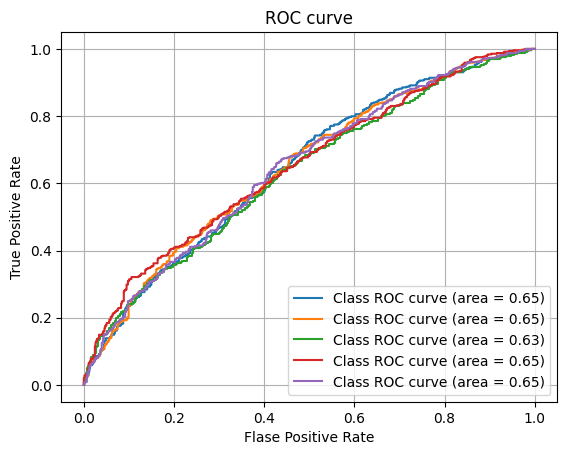

In [ ]:
# 分析評価
for model in models:
    rmse = validate_model_classification(model, df_test, explanatory_cols, target_col)